In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)

In [2]:
signals_mc_spec = [ # name, weight, energy, ewidth, radius, rwidth
    ('A',10,3,1,3,1),
    ('B',10,3,1,7,1),
    ('C',10,7,1,3,1),
    ('D',10,7,1,7,1)
]

poisson_means = [200,100,100,50]

def gen_fake(filename,energy,ewidth,radius,rwidth,num=10000):
    e = np.random.normal(energy,ewidth,num)
    r = np.random.normal(radius,rwidth,num)
    data = np.asarray([e,r]).T
    if filename:
        np.save(filename,data)
    else:
        return data
    
for name, weight, energy, ewidth, radius, rwidth in signals_mc_spec:
    for i in range(weight):
        gen_fake('data/%s_%i.npy'%(name,i),energy, ewidth, radius, rwidth)

for i in range(250):
    means = np.random.poisson(poisson_means)
    data = []
    for j, (name, weight, energy, ewidth, radius, rwidth) in enumerate(signals_mc_spec):
        s_data = gen_fake(None, energy, ewidth, radius, rwidth, num=means[j])
        data.append(s_data)
    data = np.concatenate(data)
    np.save('data/raw_data_%i.npy'%i,data)

In [3]:
from kdfit.calculate import System
from kdfit.analysis import Analysis
from kdfit.data import NPYData

In [4]:
a = Analysis()
obs = a.add_observables('Scint_Phase')
e_scale,e_shift,e_res = obs.add_dimension('Energy',0,10)
r_scale,r_shift,r_res = obs.add_dimension('Radius',0,10)
A_sig = obs.add_signal('A_pdf')
B_sig = obs.add_signal('B_pdf')
C_sig = obs.add_signal('C_pdf')
D_sig = obs.add_signal('D_pdf')

In [5]:
mc_files = dict(Scint_Phase=dict(A_pdf=NPYData('A_mc_loader',glob('data/A_*.npy'),indexes=[0,1]),
                                B_pdf=NPYData('B_mc_loader',glob('data/B_*.npy'),indexes=[0,1]),
                                C_pdf=NPYData('C_mc_loader',glob('data/C_*.npy'),indexes=[0,1]),
                                D_pdf=NPYData('D_mc_loader',glob('data/D_*.npy'),indexes=[0,1])))
a.load_mc(mc_files)

In [6]:
a.load_data(dict(Scint_Phase=NPYData('data_loader',['data/raw_data_0.npy'],indexes=[0,1])))

In [7]:
A_sig.nev_param.value = poisson_means[0]
A_sig.nev_param.fixed = False
B_sig.nev_param.value = poisson_means[1]
B_sig.nev_param.fixed = False
C_sig.nev_param.value = poisson_means[2]
C_sig.nev_param.fixed = False
D_sig.nev_param.value = poisson_means[3]
D_sig.nev_param.fixed = False
a.create_likelihood(verbose=True)

Ouput Values: [Total_Likelihood]
Scint_Phase_UnbinnedLikelihood => Total_Likelihood
A_pdf_nev => Scint_Phase_UnbinnedLikelihood
B_pdf_nev => Scint_Phase_UnbinnedLikelihood
C_pdf_nev => Scint_Phase_UnbinnedLikelihood
D_pdf_nev => Scint_Phase_UnbinnedLikelihood
A_pdf => Scint_Phase_UnbinnedLikelihood
B_pdf => Scint_Phase_UnbinnedLikelihood
C_pdf => Scint_Phase_UnbinnedLikelihood
D_pdf => Scint_Phase_UnbinnedLikelihood
Scint_Phase => Scint_Phase_UnbinnedLikelihood
A_pdf_mc => A_pdf
Energy_scale => A_pdf
Energy_shift => A_pdf
Energy_resolution => A_pdf
Radius_scale => A_pdf
Radius_shift => A_pdf
Radius_resolution => A_pdf
B_pdf_mc => B_pdf
Energy_scale => B_pdf
Energy_shift => B_pdf
Energy_resolution => B_pdf
Radius_scale => B_pdf
Radius_shift => B_pdf
Radius_resolution => B_pdf
C_pdf_mc => C_pdf
Energy_scale => C_pdf
Energy_shift => C_pdf
Energy_resolution => C_pdf
Radius_scale => C_pdf
Radius_shift => C_pdf
Radius_resolution => C_pdf
D_pdf_mc => D_pdf
Energy_scale => D_pdf
Energy_shift =

In [8]:
%prun a(verbose=True) #calculate the likelihood at central values to load data & mc 

Changed input: A_pdf_nev None => 200
Changed input: B_pdf_nev None => 100
Changed input: C_pdf_nev None => 100
Changed input: D_pdf_nev None => 50
Changed input: Energy_scale None => 1.0
Changed input: Energy_shift None => 0.0
Changed input: Energy_resolution None => 0.0
Changed input: Radius_scale None => 1.0
Changed input: Radius_shift None => 0.0
Changed input: Radius_resolution None => 0.0
Top-level recompute: [Scint_Phase_UnbinnedLikelihood A_pdf B_pdf C_pdf D_pdf A_mc_loader
 B_mc_loader C_mc_loader D_mc_loader data_loader]
Testing Scint_Phase_UnbinnedLikelihood parents: A_pdf_nev:False, B_pdf_nev:False, C_pdf_nev:False, D_pdf_nev:False, A_pdf:True, B_pdf:True, C_pdf:True, D_pdf:True, Scint_Phase:True
Testing A_pdf parents: A_pdf_mc:True, Energy_scale:False, Energy_shift:False, Energy_resolution:False, Radius_scale:False, Radius_shift:False, Radius_resolution:False
Testing B_pdf parents: B_pdf_mc:True, Energy_scale:False, Energy_shift:False, Energy_resolution:False, Radius_scale:

rough int 1.003096950746013


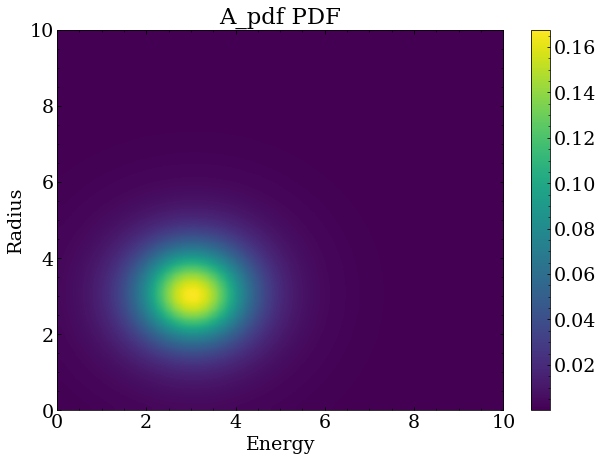

rough int 1.0030862865119987


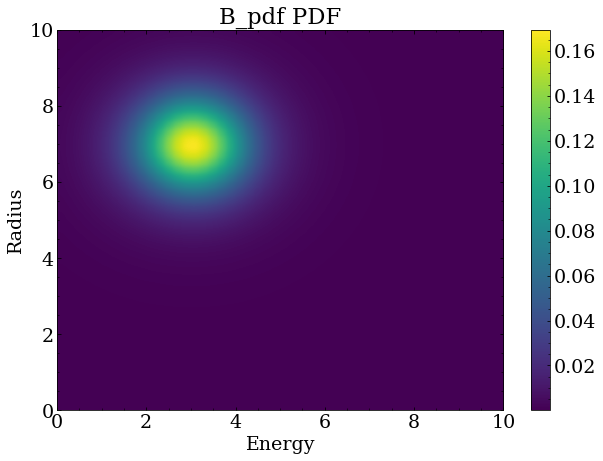

rough int 1.0031218601507885


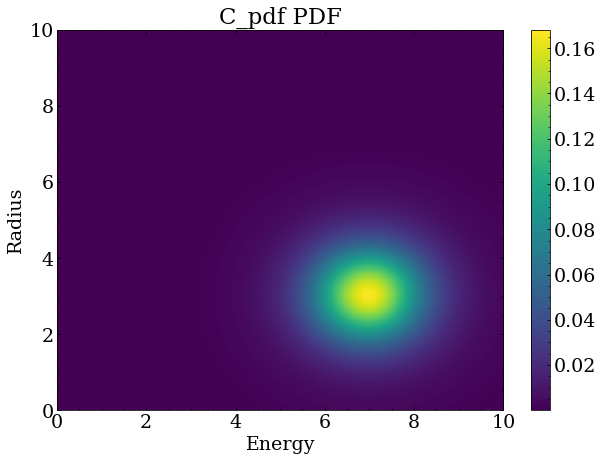

rough int 1.0030953326870802


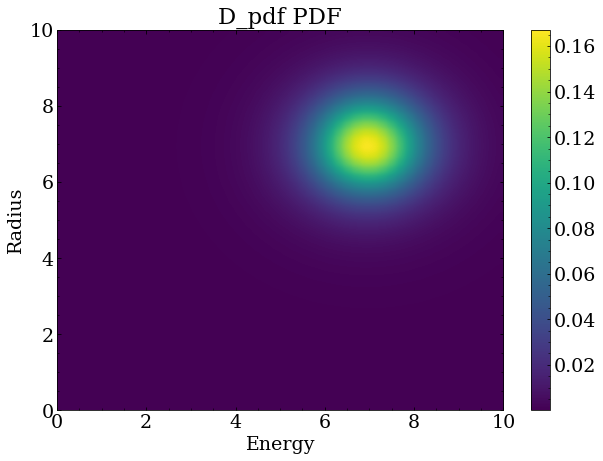

In [9]:
for s in obs.signals.values():
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = list(zip(X.flatten(),Y.flatten()))
    Z = s.eval_pdf_multi(x_kj)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF'%s.name)
    plt.show()
    plt.close()

In [10]:
def gauss(x,m,s):
    return 1/np.sqrt(2*np.pi)/s*np.exp(-np.square((x-m)/s)/2)
from scipy.special import erf
def analytic_norm(energy,ewidth,radius,rwidth):
    a = obs.lows
    b = obs.highs
    m = np.asarray([energy,radius])
    s = np.asarray([ewidth,rwidth])
    d = 2
    return np.prod( erf((b-m)/s/np.sqrt(2)) - erf((a-m)/s/np.sqrt(2))  )/(2**d)
def analytic_pdf(x_kj,energy,ewidth,radius,rwidth):
    return gauss(x_kj[:,0],energy,ewidth)*gauss(x_kj[:,1],radius,rwidth)/analytic_norm(energy,ewidth,radius,rwidth)

rough int 0.13296335363145098


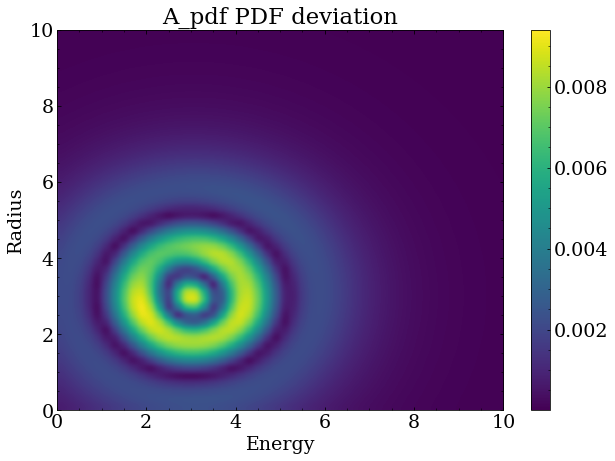

rough int 0.1343376546584604


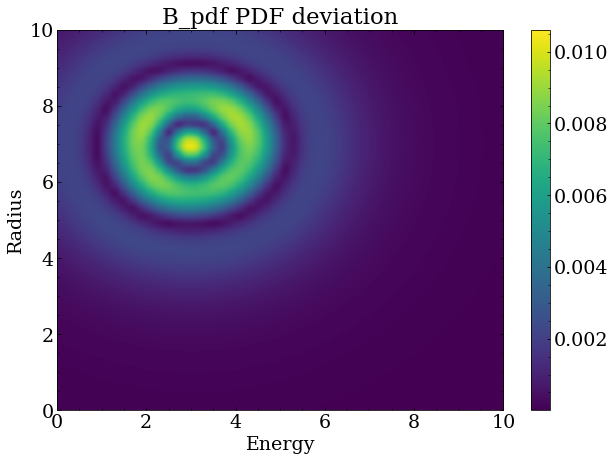

rough int 0.13477546957853093


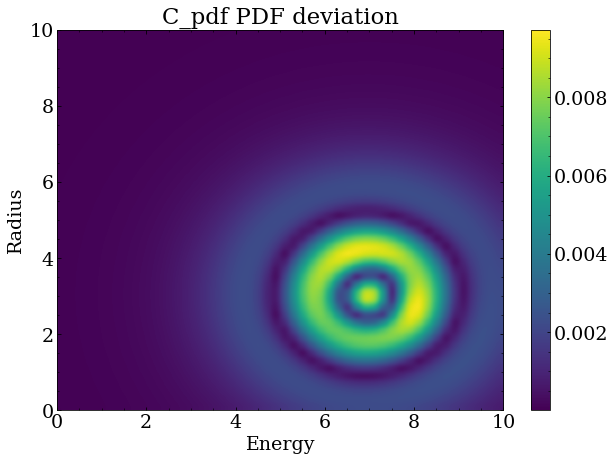

rough int 0.1325293269697806


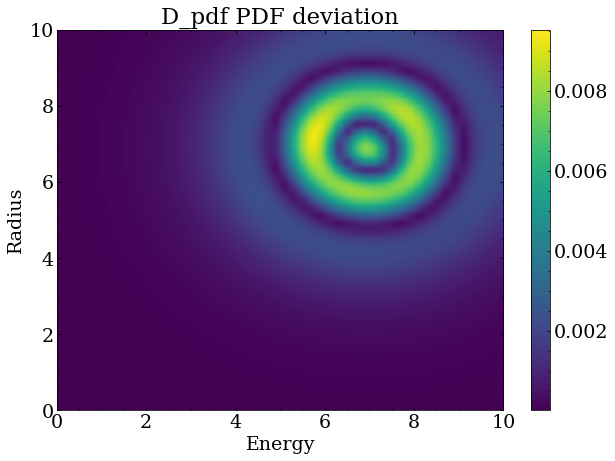

In [11]:
#The structure in the deviations is utterly bizarre to me
for j,s in enumerate(obs.signals.values()):
    name, weight, energy, ewidth, radius, rwidth = signals_mc_spec[j]
    Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
    X,Y = np.meshgrid(Xv,Yv)
    x_kj = np.asarray(list(zip(X.flatten(),Y.flatten())))
    Z = s.eval_pdf_multi(x_kj)
    analytic_Z = analytic_pdf(x_kj,energy,ewidth,radius,rwidth)
    Z = np.abs(Z - analytic_Z)
    print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
    Z = np.asarray(Z).reshape(X.shape)
    plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
    plt.colorbar()
    #plt.scatter(*(s.t_ij.T if np == cp else s.t_ij.T.get()),c='r',marker='x')
    plt.xlim(obs.lows[0],obs.highs[0])
    plt.ylim(obs.lows[1],obs.highs[1])
    plt.xlabel(obs.dimensions[0])
    plt.ylabel(obs.dimensions[1])
    plt.title('%s PDF deviation'%s.name)
    plt.show()
    plt.close()

rough int 1.0030999365551898


Text(0, 0.5, 'Radius')

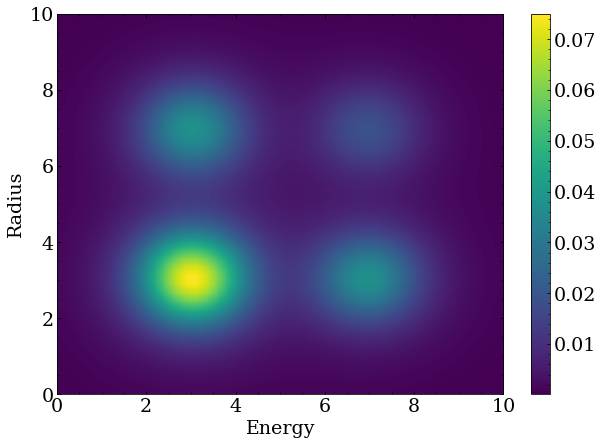

In [12]:
Xv,Yv = np.linspace(obs.lows[0],obs.highs[0],50),np.linspace(obs.lows[1],obs.highs[1],50)
X,Y = np.meshgrid(Xv,Yv)
x_kj = list(zip(X.flatten(),Y.flatten()))
Z = obs.eval_pdf_multi(x_kj)
print('rough int',np.sum(Z)*(Xv[1]-Xv[0])*(Yv[1]-Yv[0]))
Z = np.asarray(Z).reshape(X.shape)
plt.imshow(Z,extent=[np.min(Xv),np.max(Xv),np.max(Yv),np.min(Yv)],aspect='auto',interpolation='gaussian')
plt.colorbar()    
#plt.scatter(*obs.x_ij.T,c='r',marker='x')
plt.xlim(obs.lows[0],obs.highs[0])
plt.ylim(obs.lows[1],obs.highs[1])
plt.xlabel(obs.dimensions[0])
plt.ylabel(obs.dimensions[1])

In [13]:
margs = dict(method='Nelder-Mead',options=dict(fatol=0.001,xatol=0.1))

In [14]:
%prun m = a.minimize(**margs)
print(m)

  final_simplex: (array([[185.55576274, 107.61303012, 101.39860215,  49.45022278],
       [185.61143821, 107.68633911, 101.37844004,  49.44229961],
       [185.54449684, 107.60534999, 101.32629738,  49.44004189],
       [185.60249176, 107.56862275, 101.32800872,  49.41473886],
       [185.5346796 , 107.61311464, 101.3141023 ,  49.36362579]]), array([-466.19461055, -466.19460134, -466.19459789, -466.19459474,
       -466.1945833 ]))
           fun: -466.1946105544291
       message: 'Optimization terminated successfully.'
          nfev: 78
           nit: 42
        params: {A_pdf_nev: 185.55576273895014, B_pdf_nev: 107.6130301224405, C_pdf_nev: 101.39860215242763, D_pdf_nev: 49.450222779687586}
        status: 0
       success: True
             x: array([185.55576274, 107.61303012, 101.39860215,  49.45022278])


Floated Parameters: [B_pdf_nev, C_pdf_nev, D_pdf_nev]
Fixed Parameters: [A_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


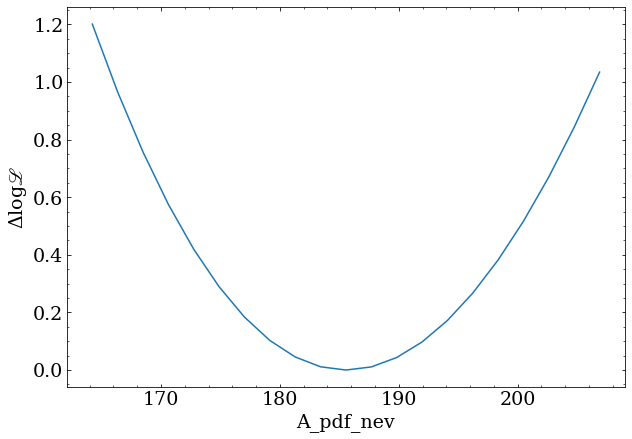

Floated Parameters: [A_pdf_nev, C_pdf_nev, D_pdf_nev]
Fixed Parameters: [B_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


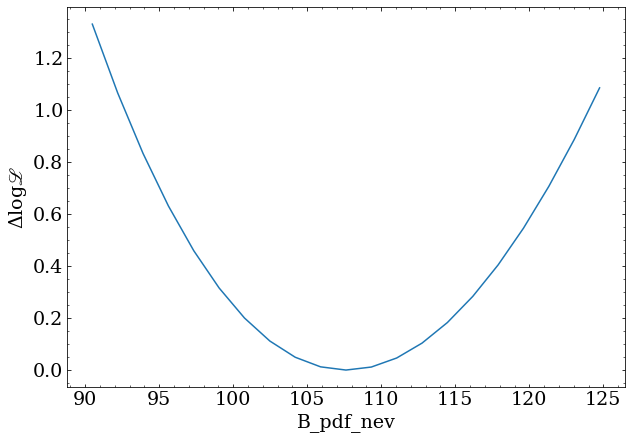

Floated Parameters: [A_pdf_nev, B_pdf_nev, D_pdf_nev]
Fixed Parameters: [C_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


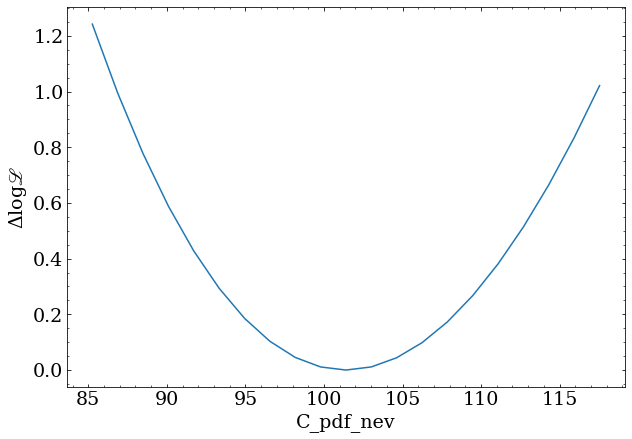

Floated Parameters: [A_pdf_nev, B_pdf_nev, C_pdf_nev]
Fixed Parameters: [D_pdf_nev, Energy_scale, Energy_shift, Energy_resolution, Radius_scale, Radius_shift, Radius_resolution]


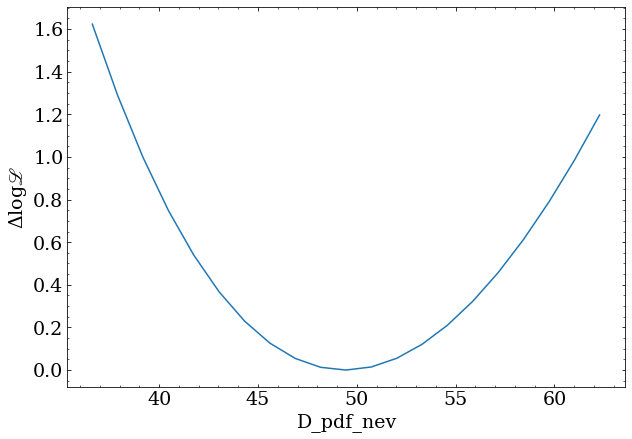

In [15]:
for _p,_v in m.params.items():
    _p.value = _v
    _p.fixed = False
for p,v in m.params.items():
    p.fixed = True
    a.update_likelihood(verbose=True)
    for step in np.logspace(-2,5,100):
        p.value = v*(1-step)
        if a() - m.fun < 1:
            continue
        p.value = v*(1+step)
        if a() - m.fun < 1:
            continue
        break
    X = np.linspace(v*(1-step),v*(1+step),21)
    Y = []
    for x in X:
        p.value = x
        nll = a() - m.fun
        Y.append(nll)
    p.fixed = False
    p.value = v
    plt.plot(X,Y)
    plt.xlabel(p.name)
    plt.ylabel(r'$\Delta$log$\scrL$')
    plt.show()
    plt.close()

In [16]:
%prun a.confidence_intervals(m,method='scan')
print(m)

  final_simplex: (array([[185.55576274, 107.61303012, 101.39860215,  49.45022278],
       [185.61143821, 107.68633911, 101.37844004,  49.44229961],
       [185.54449684, 107.60534999, 101.32629738,  49.44004189],
       [185.60249176, 107.56862275, 101.32800872,  49.41473886],
       [185.5346796 , 107.61311464, 101.3141023 ,  49.36362579]]), array([-466.19461055, -466.19460134, -466.19459789, -466.19459474,
       -466.1945833 ]))
           fun: -466.1946105544291
         lower: {A_pdf_nev: 13.950123818891655, B_pdf_nev: 10.71619028526753, C_pdf_nev: 10.44793109557618, D_pdf_nev: 7.4295638870341065}
       message: 'Optimization terminated successfully.'
          nfev: 78
           nit: 42
        params: {A_pdf_nev: 185.55576273895014, B_pdf_nev: 107.6130301224405, C_pdf_nev: 101.39860215242763, D_pdf_nev: 49.450222779687586}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.681222481122717, B_pdf_nev: 11.46569789622167, C_pdf_nev: 11.13869043566821, D_pdf_nev

In [ ]:
minima = []
for i in range(250):
    a.load_data(dict(Scint_Phase=NPYData('data_loader',['data/raw_data_%i.npy'%i],indexes=[0,1])))
    a.create_likelihood()
    m = a.minimize(**margs)
    m = a.confidence_intervals(m,method='scan')
    minima.append(m)
    print(m)

Loading: data/raw_data_0.npy
 final_simplex: (array([[185.61344492, 107.62036582, 101.437097  ,  49.40710242],
       [185.55576274, 107.61303012, 101.39860215,  49.45022278],
       [185.6197935 , 107.66255054, 101.39031957,  49.43867058],
       [185.52227093, 107.62635081, 101.38586918,  49.35369027],
       [185.54225778, 107.67660836, 101.44251363,  49.43288851]]), array([-466.1946163 , -466.19461055, -466.19461045, -466.19460432,
       -466.19460296]))
           fun: -466.19461629925365
         lower: {A_pdf_nev: 14.010835160205659, B_pdf_nev: 10.722878042667901, C_pdf_nev: 10.485928191059813, D_pdf_nev: 7.38852101942593}
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 46
        params: {A_pdf_nev: 185.61344492046646, B_pdf_nev: 107.62036582022121, C_pdf_nev: 101.43709700197154, D_pdf_nev: 49.40710242143777}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.620439367883392, B_pdf_nev: 11.459018045319723, C_pdf_nev

 final_simplex: (array([[197.48333842,  82.86809957,  99.65863603,  48.98621202],
       [197.40426031,  82.85085259,  99.72230514,  48.95957007],
       [197.52364702,  82.88937224,  99.75827191,  48.97635728],
       [197.50011767,  82.96346505,  99.67672965,  48.95663375],
       [197.57010059,  82.88187488,  99.68411523,  48.92275785]]), array([-413.97560927, -413.97559663, -413.9755802 , -413.97557787,
       -413.97556725]))
           fun: -413.9756092717912
         lower: {A_pdf_nev: 14.473970016673235, B_pdf_nev: 9.599139194223454, C_pdf_nev: 10.432177110132784, D_pdf_nev: 7.44582939971103}
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 54
        params: {A_pdf_nev: 197.48333842060484, B_pdf_nev: 82.86809956550559, C_pdf_nev: 99.65863602682762, D_pdf_nev: 48.986212022073914}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.13314876506007, B_pdf_nev: 10.356663398270285, C_pdf_nev: 11.197324180859894, D_pdf_nev: 

 final_simplex: (array([[196.5894735 ,  89.93033443,  88.82589964,  49.68510076],
       [196.62306753,  89.96811493,  88.81584142,  49.68807385],
       [196.62050625,  89.96612648,  88.77396543,  49.65005444],
       [196.51020713,  89.9656939 ,  88.82963852,  49.66685086],
       [196.61705266,  89.98178991,  88.87592595,  49.63541258]]), array([-452.88259032, -452.88257707, -452.88257452, -452.88257328,
       -452.88256021]))
           fun: -452.8825903171374
         lower: {A_pdf_nev: 14.33627516475778, B_pdf_nev: 9.794923003114206, C_pdf_nev: 9.88397385385099, D_pdf_nev: 7.366674563009305}
       message: 'Optimization terminated successfully.'
          nfev: 113
           nit: 65
        params: {A_pdf_nev: 196.58947350454133, B_pdf_nev: 89.93033443202842, C_pdf_nev: 88.82589964497005, D_pdf_nev: 49.68510076454652}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.03625871001475, B_pdf_nev: 10.49521813140288, C_pdf_nev: 10.593459064853604, D_pdf_nev: 8.0

 final_simplex: (array([[226.45974044, 103.11745909, 101.88660708,  47.464584  ],
       [226.51132236, 103.12287202, 101.95774035,  47.41730993],
       [226.4421927 , 103.14486688, 101.85047676,  47.42359421],
       [226.37247731, 103.09436777, 101.92044686,  47.44105339],
       [226.41356861, 103.0501051 , 101.91378973,  47.40486107]]), array([-542.39920644, -542.39919874, -542.39918415, -542.39917485,
       -542.39914568]))
           fun: -542.399206441717
         lower: {A_pdf_nev: 15.420651228187495, B_pdf_nev: 10.600992042766066, C_pdf_nev: 10.546524176352023, D_pdf_nev: 7.29187689182082}
       message: 'Optimization terminated successfully.'
          nfev: 100
           nit: 56
        params: {A_pdf_nev: 226.45974043947558, B_pdf_nev: 103.11745908735466, C_pdf_nev: 101.88660707525125, D_pdf_nev: 47.46458400029795}
        status: 0
       success: True
         upper: {A_pdf_nev: 16.200348743219763, B_pdf_nev: 11.367261365270892, C_pdf_nev: 11.324714513236543, D_pdf_ne

 final_simplex: (array([[190.17884714,  91.82467358, 120.94859653,  42.00217706],
       [190.09696276,  91.83355232, 121.02824797,  41.99857087],
       [190.15054452,  91.789149  , 120.97072899,  42.0107502 ],
       [190.08071321,  91.82370425, 120.95324883,  42.00695411],
       [190.0877425 ,  91.85057141, 121.02083232,  42.06154509]]), array([-499.34284655, -499.34284647, -499.34284501, -499.34283249,
       -499.3428133 ]))
           fun: -499.34284654926745
         lower: {A_pdf_nev: 14.18793942777279, B_pdf_nev: 9.959066194193085, C_pdf_nev: 11.274573884403168, D_pdf_nev: 6.7748979145953925}
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 57
        params: {A_pdf_nev: 190.1788471395516, B_pdf_nev: 91.82467357972072, C_pdf_nev: 120.94859653107345, D_pdf_nev: 42.00217705913599}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.861180787942459, B_pdf_nev: 10.690818696607124, C_pdf_nev: 12.09021741585643, D_pdf_nev:

 final_simplex: (array([[196.7518612 , 111.1407482 , 109.99011775,  59.09441608],
       [196.69353488, 111.13354512, 110.01540057,  59.10326637],
       [196.70611485, 111.10443424, 109.99430301,  59.11466722],
       [196.69602998, 111.15819447, 109.96481408,  59.11039132],
       [196.6931001 , 111.13579226, 110.01118358,  59.08291299]]), array([-549.45675374, -549.45675017, -549.45674694, -549.45674638,
       -549.45674489]))
           fun: -549.456753737146
         lower: {A_pdf_nev: 14.37162728881637, B_pdf_nev: 10.928818727096328, C_pdf_nev: 10.834167665990847, D_pdf_nev: 8.072302164004704}
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 53
        params: {A_pdf_nev: 196.75186119881954, B_pdf_nev: 111.14074820341746, C_pdf_nev: 109.99011774943887, D_pdf_nev: 59.09441608455104}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.05171963321385, B_pdf_nev: 11.656891746944979, C_pdf_nev: 11.571147669773097, D_pdf_nev:

 final_simplex: (array([[210.50088435, 110.28030802, 116.41054591,  43.85706396],
       [210.44347166, 110.32864813, 116.38384861,  43.85797002],
       [210.46180752, 110.31892648, 116.38647337,  43.88069794],
       [210.44872968, 110.27328294, 116.3594316 ,  43.88826968],
       [210.58086265, 110.28634397, 116.35646884,  43.83962548]]), array([-570.48897731, -570.48896496, -570.48896377, -570.48896361,
       -570.48895509]))
           fun: -570.4889773148523
         lower: {A_pdf_nev: 14.926385258824041, B_pdf_nev: 10.791980193843045, C_pdf_nev: 11.304483510335885, D_pdf_nev: 6.993305333342036}
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 56
        params: {A_pdf_nev: 210.5008843539131, B_pdf_nev: 110.28030801927548, C_pdf_nev: 116.41054590777645, D_pdf_nev: 43.857063960363014}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.588032409908408, B_pdf_nev: 11.486200074165524, C_pdf_nev: 11.975381445129017, D_pdf_n

 final_simplex: (array([[191.70514339,  85.46130549, 105.56630601,  45.23484224],
       [191.74691526,  85.48407025, 105.55450405,  45.23573181],
       [191.76017355,  85.50345787, 105.58320076,  45.24546131],
       [191.72587939,  85.4860667 , 105.55988995,  45.20038719],
       [191.63199652,  85.50660395, 105.55408032,  45.22766178]]), array([-448.26294393, -448.26294271, -448.26293653, -448.26293301,
       -448.26293006]))
           fun: -448.2629439281427
         lower: {A_pdf_nev: 14.231044693003383, B_pdf_nev: 9.574525482049708, C_pdf_nev: 10.753177433531945, D_pdf_nev: 7.065280895815853}
       message: 'Optimization terminated successfully.'
          nfev: 115
           nit: 65
        params: {A_pdf_nev: 191.7051433872886, B_pdf_nev: 85.46130548568487, C_pdf_nev: 105.56630601045822, D_pdf_nev: 45.2348422444327}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.94245656353101, B_pdf_nev: 10.338363539100996, C_pdf_nev: 11.482295076115577, D_pdf_nev: 

 final_simplex: (array([[192.62290812, 101.5419247 , 105.08009222,  39.67721897],
       [192.64531502, 101.58893914, 105.09310887,  39.61651766],
       [192.65171865, 101.60642394, 105.10499146,  39.70113683],
       [192.56952333, 101.54612162, 105.16870547,  39.60725165],
       [192.5549114 , 101.57276711, 105.09085321,  39.61037552]]), array([-485.4843635 , -485.48435826, -485.48435001, -485.48432822,
       -485.48432757]))
           fun: -485.48436349573444
         lower: {A_pdf_nev: 14.182874680264945, B_pdf_nev: 10.472114071731497, C_pdf_nev: 10.575392467576478, D_pdf_nev: 6.816865272308561}
       message: 'Optimization terminated successfully.'
          nfev: 121
           nit: 69
        params: {A_pdf_nev: 192.62290811950686, B_pdf_nev: 101.54192469596282, C_pdf_nev: 105.08009222458037, D_pdf_nev: 39.67721896984513}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.962101170485596, B_pdf_nev: 11.234861871628326, C_pdf_nev: 11.372271008824043, D_pdf

 final_simplex: (array([[211.93448206,  95.69047123,  97.95355141,  47.44766016],
       [212.01114621,  95.6627866 ,  97.90612257,  47.43705098],
       [211.91110191,  95.69158008,  97.8958636 ,  47.44149276],
       [211.97939061,  95.59643583,  97.92741761,  47.48524228],
       [211.90053374,  95.71148566,  97.89761526,  47.47630093]]), array([-512.22297319, -512.22297039, -512.22296531, -512.22296281,
       -512.22295588]))
           fun: -512.2229731859161
         lower: {A_pdf_nev: 14.952163293800794, B_pdf_nev: 10.251325100123111, C_pdf_nev: 10.404330279019419, D_pdf_nev: 7.247474130180358}
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 43
        params: {A_pdf_nev: 211.9344820597869, B_pdf_nev: 95.69047123200295, C_pdf_nev: 97.95355140631199, D_pdf_nev: 47.44766015800788}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.68572866741863, B_pdf_nev: 10.905795768424582, C_pdf_nev: 11.077638317477351, D_pdf_nev: 

 final_simplex: (array([[197.69000571, 102.21733604,  81.56674109,  49.51489908],
       [197.78962551, 102.20351653,  81.51435362,  49.53317857],
       [197.70186046, 102.15775165,  81.5159409 ,  49.49686153],
       [197.68102689, 102.2796464 ,  81.53210864,  49.49368134],
       [197.72244956, 102.20036224,  81.566029  ,  49.45392549]]), array([-447.12696393, -447.12695865, -447.12694803, -447.1269467 ,
       -447.12693904]))
           fun: -447.1269639341354
         lower: {A_pdf_nev: 14.392700695879597, B_pdf_nev: 10.552918281202821, C_pdf_nev: 9.564328075365182, D_pdf_nev: 7.500857189208709}
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 55
        params: {A_pdf_nev: 197.69000571449024, B_pdf_nev: 102.21733604039623, C_pdf_nev: 81.56674108877299, D_pdf_nev: 49.51489908266682}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.170888508922218, B_pdf_nev: 11.27039433487731, C_pdf_nev: 10.241695993321898, D_pdf_nev:

 final_simplex: (array([[193.55013024, 104.97887007,  90.66765547,  53.78790408],
       [193.63338281, 105.04083054,  90.61590962,  53.78854585],
       [193.60141397, 105.04173047,  90.65671974,  53.77185631],
       [193.57404517, 104.98817391,  90.61671232,  53.75584415],
       [193.60011152, 104.96412807,  90.67627892,  53.77569655]]), array([-487.69327891, -487.69327377, -487.69326981, -487.69326819,
       -487.69326007]))
           fun: -487.69327891499483
         lower: {A_pdf_nev: 14.232300287558672, B_pdf_nev: 10.61929364117853, C_pdf_nev: 10.02157483153357, D_pdf_nev: 7.7989311018832765}
       message: 'Optimization terminated successfully.'
          nfev: 77
           nit: 41
        params: {A_pdf_nev: 193.55013023925636, B_pdf_nev: 104.97887006965233, C_pdf_nev: 90.66765547388022, D_pdf_nev: 53.78790408164116}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.944432713923362, B_pdf_nev: 11.391926260910296, C_pdf_nev: 10.658671401757047, D_pdf_ne

 final_simplex: (array([[212.56448353,  93.96533222,  95.50167572,  36.89619686],
       [212.65354255,  93.98701603,  95.5342778 ,  36.88101489],
       [212.63280739,  93.89736784,  95.51491565,  36.91334084],
       [212.59299963,  93.9301124 ,  95.55176775,  36.90963459],
       [212.66097978,  93.94207631,  95.55147053,  36.87028845]]), array([-504.75559938, -504.75559631, -504.75558932, -504.75558788,
       -504.7555819 ]))
           fun: -504.7555993823485
         lower: {A_pdf_nev: 14.865562756725893, B_pdf_nev: 10.141582505634432, C_pdf_nev: 10.164190398252117, D_pdf_nev: 6.461852036293017}
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 56
        params: {A_pdf_nev: 212.56448352991305, B_pdf_nev: 93.96533221921571, C_pdf_nev: 95.50167571811572, D_pdf_nev: 36.89619686130142}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.70883253498252, B_pdf_nev: 10.863240135646592, C_pdf_nev: 10.875883432818213, D_pdf_nev:

 final_simplex: (array([[178.11623983,  88.84948895,  92.2053973 ,  41.78613537],
       [178.19874031,  88.84724082,  92.19649632,  41.80429388],
       [178.16057414,  88.82252669,  92.2053627 ,  41.80562694],
       [178.15898005,  88.86818117,  92.21090028,  41.81353889],
       [178.17839744,  88.84930112,  92.16511475,  41.81725199]]), array([-392.38706745, -392.38706418, -392.38706334, -392.3870618 ,
       -392.38705537]))
           fun: -392.38706744903635
         lower: {A_pdf_nev: 13.6291211388112, B_pdf_nev: 9.788379764923178, C_pdf_nev: 10.02078847289144, D_pdf_nev: 6.885314201921787}
       message: 'Optimization terminated successfully.'
          nfev: 158
           nit: 93
        params: {A_pdf_nev: 178.1162398266108, B_pdf_nev: 88.84948895417052, C_pdf_nev: 92.20539730000874, D_pdf_nev: 41.786135368144926}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.419331053517539, B_pdf_nev: 10.515245296143405, C_pdf_nev: 10.73163267860329, D_pdf_nev: 7

 final_simplex: (array([[207.21295743, 100.89891   ,  96.62924559,  47.21797134],
       [207.28602293, 100.9461132 ,  96.62330058,  47.18396609],
       [207.18482906, 100.95863373,  96.64143549,  47.2062676 ],
       [207.23145797, 100.9161404 ,  96.62916689,  47.24678918],
       [207.17820841, 100.91312909,  96.59487929,  47.22447985]]), array([-522.68545007, -522.6854441 , -522.68544327, -522.68544165,
       -522.68543842]))
           fun: -522.68545006521
         lower: {A_pdf_nev: 14.69914130157602, B_pdf_nev: 10.429848126264687, C_pdf_nev: 10.162703699381126, D_pdf_nev: 7.154044515288263}
       message: 'Optimization terminated successfully.'
          nfev: 84
           nit: 49
        params: {A_pdf_nev: 207.21295742747793, B_pdf_nev: 100.89890999757682, C_pdf_nev: 96.62924558836457, D_pdf_nev: 47.21797133618752}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.458972167792183, B_pdf_nev: 11.194753140689969, C_pdf_nev: 10.869073047019924, D_pdf_nev: 

 final_simplex: (array([[178.0905989 , 106.74444824,  88.69073291,  49.52879274],
       [178.00812118, 106.73948598,  88.69392365,  49.52734707],
       [178.07169824, 106.75891017,  88.62773233,  49.51906609],
       [178.10361547, 106.69037473,  88.63071983,  49.54358192],
       [178.05119658, 106.7605185 ,  88.61327897,  49.56786494]]), array([-409.76199024, -409.7619888 , -409.76198246, -409.76196833,
       -409.76196323]))
           fun: -409.7619902406161
         lower: {A_pdf_nev: 13.833108656256428, B_pdf_nev: 10.825250240887797, C_pdf_nev: 9.878977156572972, D_pdf_nev: 7.4635476889385615}
       message: 'Optimization terminated successfully.'
          nfev: 107
           nit: 56
        params: {A_pdf_nev: 178.09059889807412, B_pdf_nev: 106.74444824068145, C_pdf_nev: 88.69073291326221, D_pdf_nev: 49.528792735266556}
        status: 0
       success: True
         upper: {A_pdf_nev: 14.460984303993285, B_pdf_nev: 11.539463139331005, C_pdf_nev: 10.570360206305295, D_pdf_

 final_simplex: (array([[228.61498868, 105.85609505, 102.66844107,  53.96326969],
       [228.5455294 , 105.84986758, 102.61813266,  53.89138535],
       [228.60651917, 105.85724024, 102.58451117,  53.93352374],
       [228.65670433, 105.78451634, 102.666295  ,  53.8690989 ],
       [228.52347284, 105.78164299, 102.71008972,  53.97156827]]), array([-594.55727059, -594.55726527, -594.55726475, -594.55724195,
       -594.55724059]))
           fun: -594.5572705885713
         lower: {A_pdf_nev: 15.50374038724587, B_pdf_nev: 10.7706965568712, C_pdf_nev: 10.582508542022865, D_pdf_nev: 7.794481888763016}
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 60
        params: {A_pdf_nev: 228.61498867518782, B_pdf_nev: 105.85609505023241, C_pdf_nev: 102.66844107294759, D_pdf_nev: 53.96326968787417}
        status: 0
       success: True
         upper: {A_pdf_nev: 16.14294627329076, B_pdf_nev: 11.424914513011899, C_pdf_nev: 11.258007502485938, D_pdf_nev:

 final_simplex: (array([[213.05077873, 101.17806192,  89.68817237,  39.09749298],
       [212.98812723, 101.1996665 ,  89.71203646,  39.09977874],
       [212.9884808 , 101.21024886,  89.71894902,  39.12026938],
       [212.96823765, 101.14762777,  89.6976538 ,  39.1105149 ],
       [213.06974543, 101.15372894,  89.72970711,  39.09099346]]), array([-497.27372438, -497.27372198, -497.27371593, -497.27371536,
       -497.27370907]))
           fun: -497.273724384111
         lower: {A_pdf_nev: 14.942377892561836, B_pdf_nev: 10.406672430512884, C_pdf_nev: 9.922011057106218, D_pdf_nev: 6.6874991739334035}
       message: 'Optimization terminated successfully.'
          nfev: 107
           nit: 61
        params: {A_pdf_nev: 213.05077872640882, B_pdf_nev: 101.17806191647759, C_pdf_nev: 89.68817236576038, D_pdf_nev: 39.09749297566416}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.581060146393668, B_pdf_nev: 11.12739811723526, C_pdf_nev: 10.647123721329862, D_pdf_nev

 final_simplex: (array([[205.96312423, 112.6736115 ,  90.25416611,  59.11547485],
       [206.02220618, 112.67320778,  90.20135553,  59.08670143],
       [206.04526817, 112.65728888,  90.29837749,  59.07696836],
       [206.01685652, 112.60400732,  90.3028694 ,  59.11522029],
       [205.93045399, 112.62023387,  90.22898706,  59.06203395]]), array([-531.166519  , -531.16651398, -531.16650314, -531.16649596,
       -531.16649537]))
           fun: -531.1665189965513
         lower: {A_pdf_nev: 14.696787805257458, B_pdf_nev: 11.079158926828683, C_pdf_nev: 10.014081028130889, D_pdf_nev: 8.148046098567939}
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 57
        params: {A_pdf_nev: 205.9631242324329, B_pdf_nev: 112.67361150037587, C_pdf_nev: 90.25416611427706, D_pdf_nev: 59.11547484933959}
        status: 0
       success: True
         upper: {A_pdf_nev: 15.46593939033471, B_pdf_nev: 11.758649214212554, C_pdf_nev: 10.719609177467873, D_pdf_nev:

In [ ]:
A_sig.nev_param.value = poisson_means[0]
A_sig.nev_param.fixed = False
B_sig.nev_param.value = poisson_means[1]
B_sig.nev_param.fixed = False
C_sig.nev_param.value = poisson_means[2]
C_sig.nev_param.fixed = False
D_sig.nev_param.value = poisson_means[3]
D_sig.nev_param.fixed = False
a.update_likelihood()
params = a._floated
central = np.asarray(poisson_means)

In [ ]:
bias = np.asarray([[(m.params[p]-c)/c for p,c in zip(params,central)] for m in minima])

In [ ]:
for p,b in zip(params,bias.T):
    print('mean',np.mean(b),'width',np.std(b))
    plt.hist(b)
    plt.xlabel('%s fractional bias'%p)
    plt.show()
    plt.close()

In [ ]:
pull = np.asarray([[b/m.lower[p] if (b:=(m.params[p]-c)) < 0 else b/m.upper[p] for p,c in zip(params,central)] for m in minima])

In [ ]:
for p,u in zip(params,pull.T):
    print(np.mean(u),np.std(u))
    plt.hist(u,bins=np.linspace(-3,3,21))
    plt.xlabel('%s pull'%p)
    plt.show()
    plt.close()

In [ ]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in pull.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Pull')

In [ ]:
dat = np.asarray([(np.mean(u),np.std(u)) for u in bias.T])
par = np.arange(len(dat))
plt.errorbar(par,dat[:,0],yerr=dat[:,1],linestyle='none',marker='o')
plt.xticks(par,params)
plt.ylabel('Bias')